In [1]:
import pandas as pd

In [2]:
# Aircraft types
aircraft_types = ["H", "L", "S"]

# Approach speeds (in knots)
speeds = {"H": 150, "L": 120, "S": 90}

# Runway occupancy times (seconds)
occupancy_times = {"H": 40, "L": 40, "S": 30}

# Approach path length (nautical miles)
n = 5

# Separation distances (nautical miles)
separation_matrix = {
    "H": {"H": 5, "L": 5, "S": 6},
    "L": {"H": 4, "L": 4, "S": 4},
    "S": {"H": 4, "L": 4, "S": 4},
}

# Convert knots to nautical miles per second (1 knot = 1.68781 ft/s = 1.15078 mph)
knots_to_nmi_per_sec = 1 / 3_600  # 1 knot = 1/3600 nmi per second

# Compute minimum time separations (T_ij)
T_ij = pd.DataFrame(index=aircraft_types, columns=aircraft_types)

for leading in aircraft_types:
    for trailing in aircraft_types:
        vi = speeds[leading] * knots_to_nmi_per_sec  # Convert speed to nmi/sec
        vj = speeds[trailing] * knots_to_nmi_per_sec
        sij = separation_matrix[leading][trailing]
        oi = occupancy_times[leading]

        # Check if it's an opening or closing case
        if vi > vj:  # Opening case
            Tij = max((n + sij) / vj - n / vi, oi)
        else:  # Closing case
            Tij = max(sij / vj, oi)

        # Store result
        T_ij.loc[leading, trailing] = round(Tij, 2)

display(T_ij)

,H,L,S
H,120.0,180.0,320.0
L,96.0,120.0,210.0
S,96.0,120.0,160.0


In [3]:
# Given aircraft mix percentages
mix_percentages = {"H": 0.25, "L": 0.50, "S": 0.25}

# Compute the probability matrix p_ij
p_ij = pd.DataFrame(index=aircraft_types, columns=aircraft_types)

for leading in aircraft_types:
    for trailing in aircraft_types:
        p_ij.loc[leading, trailing] = mix_percentages[leading] * mix_percentages[trailing]

# Convert to numeric for calculations
p_ij = p_ij.astype(float)

# Compute expected time separation E(T_ij)
E_Tij = (p_ij * T_ij).sum().sum()

# Display results
E_Tij

149.25

In [4]:
# Runway landing capacity
runway_capacity = 3_600/E_Tij
runway_capacity

24.12060301507538

In [5]:
# Compute expected squared separation time E[T_ij^2]
E_Tij_squared = (p_ij * (T_ij.astype(float) ** 2)).sum().sum()

# Compute variance of separation time Var(T_ij)
Var_Tij = E_Tij_squared - (E_Tij ** 2)

# Display results
Var_Tij

3314.9375

In [6]:
arrival_rate = 20

# Compute utilization factor (rho)
rho = arrival_rate / runway_capacity

# Convert seconds² to hours²
Var_Tij = Var_Tij / (3600 ** 2)

# Compute expected system occupancy (L)
L = rho + (rho**2 + (arrival_rate**2) * Var_Tij) / (2 * (1 - rho))

# Compute expected system time (W)
W = L / arrival_rate

# Compute average delay in queue (W_q)
W_q = W - (1 / runway_capacity)

# Convert to minutes
W_q_minutes = W_q * 60

# Display result
W_q_minutes

6.935094850948505

In [7]:
# Given aircraft mix: S = 25%, L = 50%, H = 25%
num_landings = 100  # Given total landings

# Compute number of landings per aircraft type
num_S = int(num_landings * 0.25)  # Small aircraft landings
num_L = int(num_landings * 0.50)  # Large aircraft landings
num_H = int(num_landings * 0.25)  # Heavy aircraft landings

# Compute number of intervals (landings - 1)
num_S_intervals = num_S - 1  # S-S intervals before transition
num_L_intervals = num_L - 1  # L-L intervals before transition
num_H_intervals = num_H - 1  # H-H intervals after transition

# Define interval sequence based on ATC rules
landing_sequence_intervals = [160] * num_S_intervals  # S-S
landing_sequence_intervals += [120]  # S-L transition
landing_sequence_intervals += [120] * num_L_intervals  # L-L
landing_sequence_intervals += [96]  # L-H transition
landing_sequence_intervals += [120] * num_H_intervals  # H-H

# Ensure total intervals sum to 99
assert len(landing_sequence_intervals) == 99, "Error: Incorrect interval count!"

# Compute total time for all intervals
total_time = sum(landing_sequence_intervals)

# Compute new runway capacity using corrected intervals
runway_capacity_ATC = 3600 / (total_time / 99)

# Display the corrected runway capacity
runway_capacity_ATC

27.80898876404494

In [8]:
from scipy.special import factorial

# Given parameters
lambda_rate = 40  # Arrival rate (customers per hour)
mu = 30  # Service rate per counter (customers per hour)
s = 2  # Number of servers in M/M/2

# Utilization factor for M/M/2 system
rho = lambda_rate / (s * mu)

# Compute P0 (probability of zero customers in system for M/M/2)
sum_term = sum((lambda_rate / mu) ** k / factorial(k) for k in range(s))
P0 = 1 / (sum_term + ((lambda_rate / mu) ** s / (factorial(s) * (1 - rho))))

# Compute Cs term
Cs = ((lambda_rate / mu) ** s) / (factorial(s) * (1 - rho))

# Compute Wq for M/M/2 system
Wq_mm2 = (Cs * P0) / (s * mu - lambda_rate)  # In hours
Wq_mm2_minutes = Wq_mm2 * 60  # Convert to minutes

# Compute Wq for M/M/1 system (already derived manually as 4 minutes)
Wq_mm1_minutes = 4

# Display results
Wq_mm2_minutes, Wq_mm1_minutes

(1.5999999999999999, 4)

'/content/drive/MyDrive/Colab/car_detector_simulation.gif'

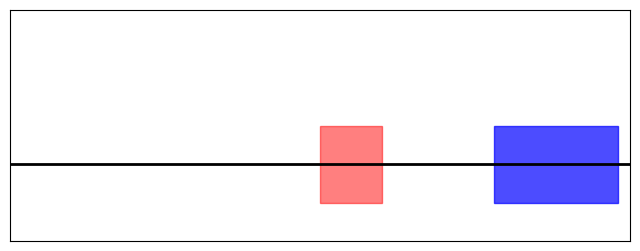

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define parameters for the simulation
road_length = 10  # Length of the road section
car_length = 2  # Length of the vehicle
detector_length = 1  # Length of the detector
detector_position = 5  # Position of the detector on the road

# Time parameters
num_frames = 50  # Number of frames in the animation
car_speed = road_length / num_frames  # Distance moved per frame

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0, road_length)
ax.set_ylim(-1, 2)
ax.set_xticks([])
ax.set_yticks([])

# Draw road
ax.plot([0, road_length], [0, 0], color='black', linewidth=2)  # Road boundary

# Draw detector
detector = plt.Rectangle((detector_position, -0.5), detector_length, 1, color='red', alpha=0.5, label="Detector Zone")
ax.add_patch(detector)

# Draw moving vehicle
car = plt.Rectangle((-car_length, -0.5), car_length, 1, color='blue', alpha=0.7, label="Vehicle")
ax.add_patch(car)

# Function to update vehicle position
def update(frame):
    car.set_x(frame * car_speed - car_length)  # Move the car
    return car,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)
ani

# Save animation as GIF
gif_path = "/content/drive/MyDrive/Colab/car_detector_simulation.gif"
ani.save(gif_path, writer='pillow', fps=20)

# Provide the GIF path for user to download
gif_path

Image saved as car_detector.png


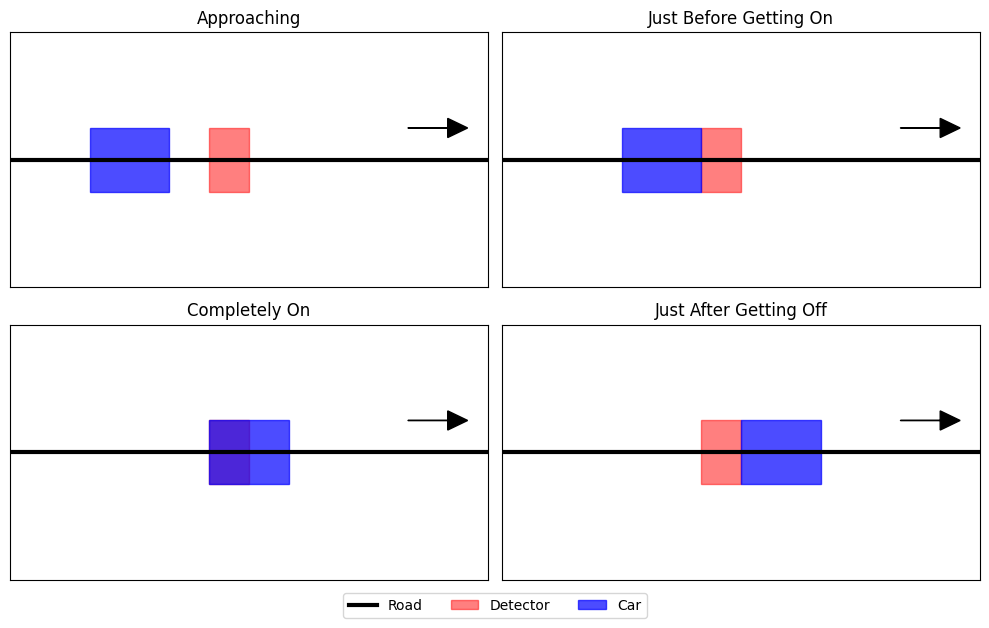

In [10]:
import matplotlib.pyplot as plt

# Define parameters
road_length = 12  # Extended for better visualization
car_length = 2
detector_length = 1
detector_position = 5  # Center of the detector zone
car_speed = road_length / 50  # Adjusted for smooth movement

# Create figure and axis for a 2x2 grid of frames
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Define key frames representing different positions of the car
key_frames = [
    detector_position - (car_length + 1),   # Approaching
    detector_position - car_length,         # Just before getting on
    detector_position,                      # Completely on
    detector_position + detector_length     # Just after getting off
]

frame_titles = ["Approaching", "Just Before Getting On", "Completely On", "Just After Getting Off"]

# Plot each key frame in a 2x2 layout
for i, (frame, title) in enumerate(zip(key_frames, frame_titles)):
    ax = axes[i // 2, i % 2]  # Convert index to 2D position
    ax.set_xlim(0, road_length)
    ax.set_ylim(-2, 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    # Draw road
    ax.plot([0, road_length], [0, 0], color='black', linewidth=3, label="Road")

    # Draw detector
    detector_patch = plt.Rectangle((detector_position, -0.5), detector_length, 1, color='red', alpha=0.5, label="Detector")
    ax.add_patch(detector_patch)

    # Draw moving vehicle (Car)
    car_patch = plt.Rectangle((frame, -0.5), car_length, 1, color='blue', alpha=0.7, label="Car")
    ax.add_patch(car_patch)

    # Add arrow to indicate direction of travel
    ax.arrow(road_length - 2, 0.5, 1, 0, head_width=0.3, head_length=0.5, fc='black', ec='black')

# Adjust layout for better spacing
plt.tight_layout()

# Add a legend outside the plot at the bottom to avoid overlap
handles = [plt.Line2D([0], [0], color='black', linewidth=3, label="Road"),
           plt.Rectangle((0, 0), 1, 1, color='red', alpha=0.5, label="Detector"),
           plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.7, label="Car")]
fig.legend(handles=handles, loc="lower center", ncol=3, fontsize=10, frameon=True, bbox_to_anchor=(0.5, -0.05))

# Save the frames as an image
plt.savefig("car_detector.png", dpi=300, bbox_inches="tight")

print("Image saved as car_detector.png")

In [11]:
# Given data for part (a)
headway_a = 2.2  # seconds
speed_a = 50  # miles per hour

# Compute flow rate (vehicles per hour)
flow_a = 3600 / headway_a  # Flow (q) = 3600 / headway

# Compute density using the fundamental equation q = k * v
density_a = flow_a / speed_a  # k = q / v

# Given data for part (b)
speed_b = 40  # miles per hour
flow_b = 1600  # vehicles per hour per lane

# Compute density for part (b)
density_b = flow_b / speed_b  # k = q / v

# Display results
flow_a, density_a, density_b

(1636.3636363636363, 32.72727272727273, 40.0)

In [12]:
# Re-import necessary libraries
import numpy as np
import pandas as pd

# Given data
detector_length = 9  # feet
observation_time = 142  # seconds
occupancy_times = np.array([0.46, 0.48, 0.53, 0.42, 0.52, 0.45])  # seconds
vehicle_lengths = np.array([18, 21, 20, 23, 17, 19])  # feet

# Conversion factors
feet_to_miles = 1 / 5280  # 5280 feet in a mile
seconds_to_hours = 3600  # 3600 seconds in an hour

# Compute occupancy percentage
total_occupancy_time = np.sum(occupancy_times)
percent_occupancy = (total_occupancy_time / observation_time) * 100

# Compute vehicle speeds factoring in detector length
vehicle_speeds = (vehicle_lengths + detector_length) / occupancy_times  # Speed in ft/sec
vehicle_speeds_mph = vehicle_speeds * feet_to_miles * seconds_to_hours  # Convert to mph
average_speed_mph = np.mean(vehicle_speeds_mph)

# Compute flow in vehicles per hour
flow = len(vehicle_lengths) / observation_time * seconds_to_hours  # Flow (q) in vehicles per hour

# Compute density in vehicles per mile
density = flow / average_speed_mph  # Density (k) in vehicles per mile

# Use average vehicle length instead
avg_vehicle_length = np.mean(vehicle_lengths)  # Compute average vehicle length
estimated_speeds = (avg_vehicle_length + detector_length) / occupancy_times  # Estimated speeds in ft/sec
estimated_speeds_mph = estimated_speeds * feet_to_miles * seconds_to_hours  # Convert to mph
estimated_avg_speed_mph = np.mean(estimated_speeds_mph)

# Compute estimated density correctly
estimated_density = flow / estimated_avg_speed_mph  # Density (k) in vehicles per mile

# Create a dictionary to store the results
results = {
    "Percent Occupancy": [percent_occupancy],
    "Average Speed (mph)": [average_speed_mph],
    "Flow (veh/hr)": [flow],
    "Density (veh/mi)": [density],
    "Estimated Avg Speed (mph)": [estimated_avg_speed_mph],
    "Estimated Density (veh/mi)": [estimated_density],
}

# Convert the dictionary to a Pandas DataFrame
results_df = pd.DataFrame(results)
results_df

,Percent Occupancy,Average Speed (mph),Flow (veh/hr),Density (veh/mi),Estimated Avg Speed (mph),Estimated Density (veh/mi)
0,2.014085,41.400606,152.112676,3.674165,41.274431,3.685397
